# $\color{palevioletred}{\text{Neural Networks and Deep Learning Project: Image Captioning}}$

---

## Project Description

---
The main objective of this project is to develop a system that can generate natural language descriptions for input images. Our approach involves integrating various models and techniques to develop a robust system that can analyze the content of images and generate descriptive captions that accurately represent the visual information.

To accomplish the goal, we will initially utilize a pre-trained Convolutional Neural Network (CNN) like ResNet, AlexNet, or VGG16 to extract significant features from the input images. 
Then, we will proceed with the TEXT THINGS......... Finally, a LSTM (Long Short Term Memory) will be used to generate the captions.

To train and evaluate our system, we will use the Flickr 8k Dataset. It contains 8,000 images, each with multiple human-annotated captions, making it suitable for training a caption generation model. The dataset can be found on platforms like Kaggle (https://www.kaggle.com/datasets/adityajn105/flickr8k).

HEOEHFIABSDBJJKB We could do something like this image but with our approach:

<img src="https://raw.githubusercontent.com/yunjey/pytorch-tutorial/master/tutorials/03-advanced/image_captioning/png/model.png" width="700">

---

## Initialization

---


### $\color{palevioletred}{\text{(1) Loading Modules and Dependencies}}$

In [3]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
from glob import glob
import wandb

import torch
import torchvision.models as models
import torchvision.transforms as transforms
# from torchtext.vocab import Vocab
# from torchtext.data.utils import get_tokenizer
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn

from tensorflow.keras.preprocessing.text import Tokenizer

#import cv2
from PIL import Image
from pathlib import Path

import matplotlib.pyplot as plt
#from sklearn.manifold import TSNE
import re
import random
from collections import Counter
import pickle as pkl

import warnings
warnings.filterwarnings('ignore')

# Set default font size
#plt.rcParams['font.size'] = 12

# Set paths to captions file and images folder
captions_file = 'dataset/captions.txt'
images_folder = 'dataset/Images'

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### $\color{palevioletred}{\text{(2) Data Exploration}}$

- Helpful Functions

In [4]:
# Extract captions from text file
def extract_captions(image_name, captions_text):
    captions = []
    for line in captions_text.splitlines():
        parts = line.split(',')
        if len(parts) == 2 and parts[0] == image_name:
            captions.append(parts[1])
    return captions

# Build a dictionary containing image names as keys and their respective captions as values
def build_captions_dict(captions_text):
    captions_dict = {}
    for line in captions_text.splitlines():
        parts = line.split(',')
        if len(parts) == 2:
            if parts[0] not in captions_dict:
                captions_dict[parts[0]] = []
            captions_dict[parts[0]].append(parts[1])
    return captions_dict

# Visualize images with captions
def visualize_images(folder_path, captions_dict, num_images_to_display=6, num_images_per_row=3, max_caption_length=40):
    file_names = [f for f in os.listdir(folder_path) if f.endswith('.jpg') or f.endswith('.png')]

    np.random.shuffle(file_names) 
    file_names = file_names[:num_images_to_display]  

    num_images = len(file_names)
    num_rows = (num_images + num_images_per_row - 1) // num_images_per_row

    fig, axes = plt.subplots(num_rows, num_images_per_row, figsize=(15, num_rows * 5))

    # If only one image is being displayed, axes won't be an array. We fix this here.
    if num_images == 1:
        axes = np.array([axes])
        
    axes = axes.flatten()  # Flatten the axes array for easier handling

    for i, file_name in enumerate(file_names):
        img_path = os.path.join(folder_path, file_name)
        img = plt.imread(img_path)
        ax = axes[i]
        ax.imshow(img)
        ax.axis('off')

        caption = captions_dict.get(file_name, ["No caption"])
        if len(caption[0]) > max_caption_length:
            caption_lines = [caption[0][0:max_caption_length], caption[0][max_caption_length:]]
            ax.text(0.5, -0.1, caption_lines[0] + '\n' + caption_lines[1], transform=ax.transAxes, fontsize=10, ha='center')
        else:
            ax.text(0.5, -0.1, caption[0], transform=ax.transAxes, fontsize=10, ha='center')

    for j in range(num_images, num_rows * num_images_per_row):
        fig.delaxes(axes[j])  # Remove the extra sub-plots

    plt.tight_layout()
    plt.show()

- Loading captions and building dictionary

In [5]:
with open(captions_file, "r") as file:
    captions_text = file.read()
captions_dict = build_captions_dict(captions_text)

- Visualizing images with captions: Sample display

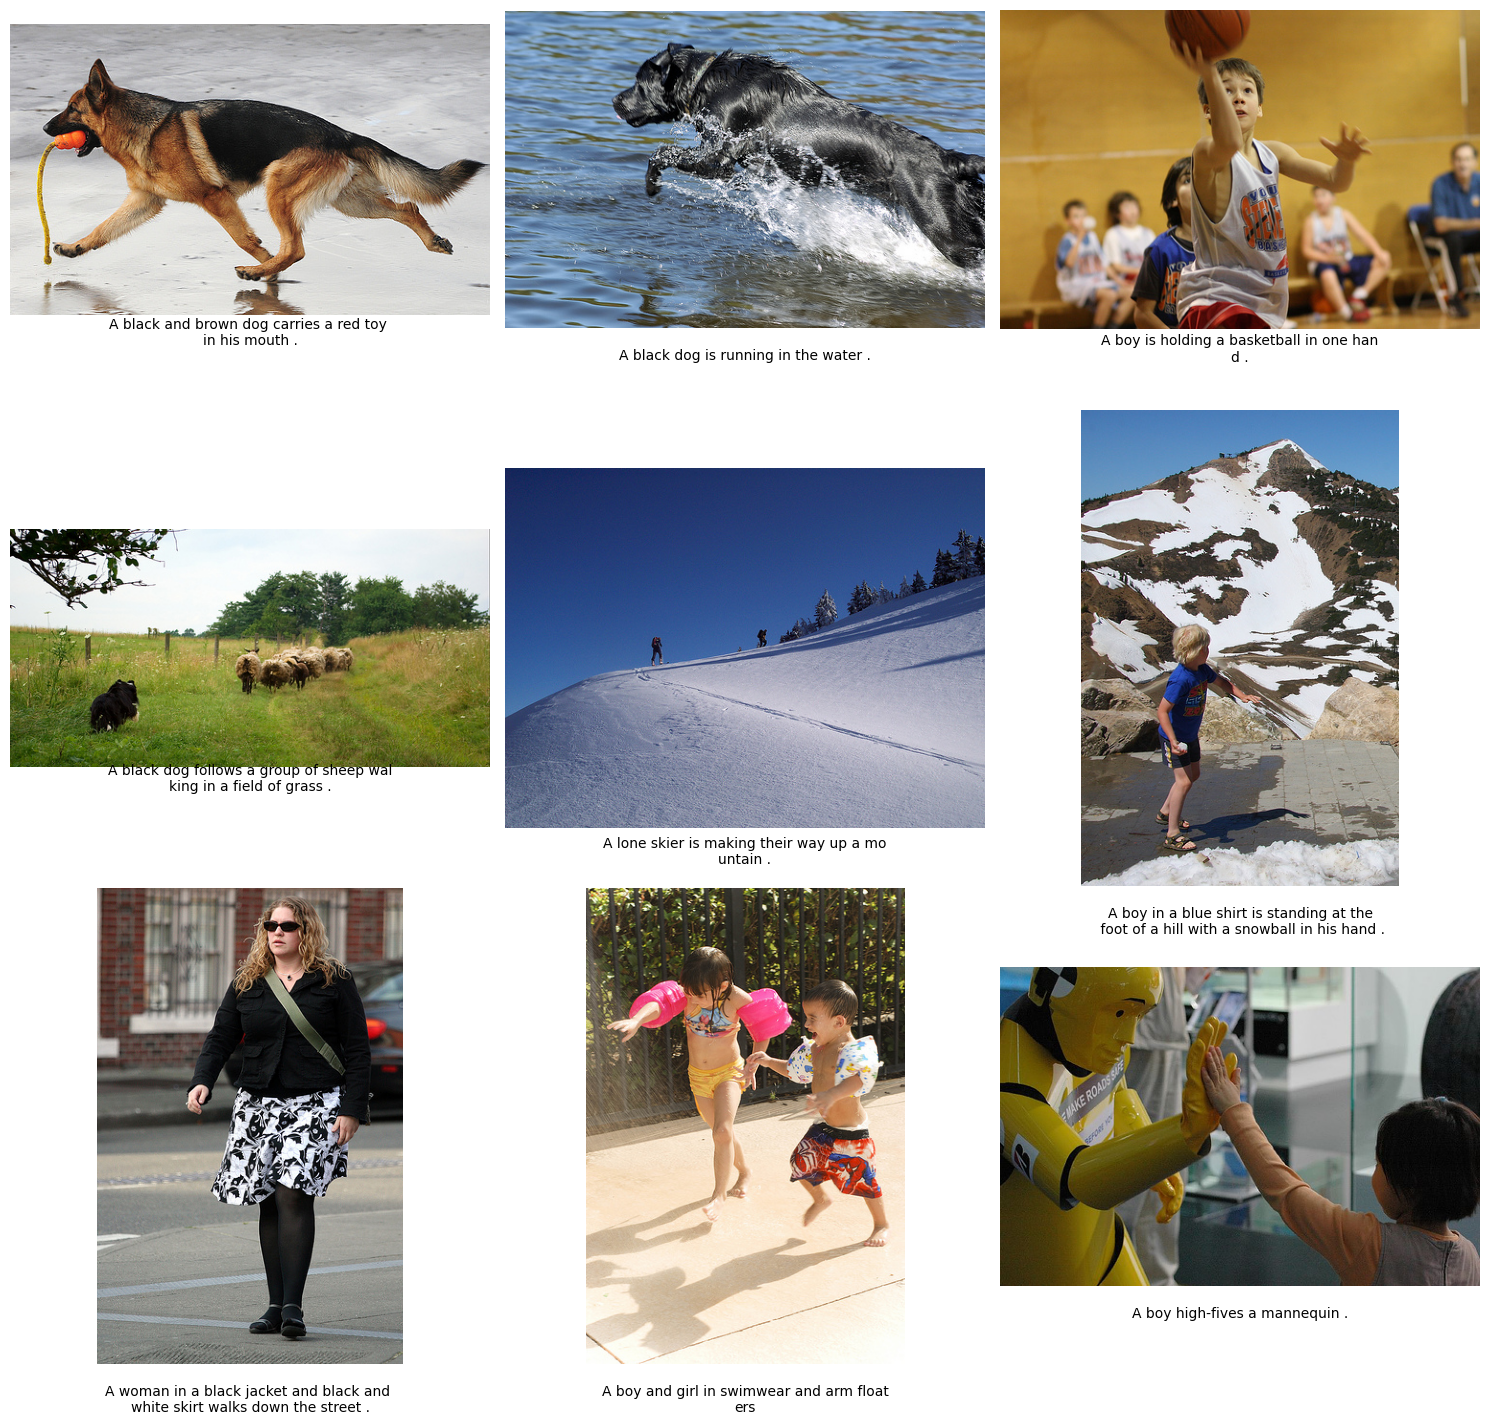

In [4]:
visualize_images(folder_path=images_folder, captions_dict=captions_dict, num_images_to_display=9, num_images_per_row=3)

---

## Data Preprocessing

---

### $\color{palevioletred}{\text{(1) Image Preprocessing: Extracting features}}$



- Image Transformations

In this section, we apply various transformations to the input images to prepare them for further processing. The transformations are as follows:

1) **Resizing:** The images are resized to a fixed size of (224, 224) pixels using the `transforms.Resize` operation. This ensures that all images have the same dimensions, which is often required by models like the feature extraction models we are working with.

2) **Conversion to Tensor:** The images are converted into PyTorch tensors using the `transforms.ToTensor` operation. This transformation converts the image data into a multi-dimensional array representation that can be processed by PyTorch.

3) **Normalization:** The images are normalized using the `transforms.Normalize` operation. This step involves subtracting the mean values [0.45802852, 0.4460975, 0.40391668] from each channel and dividing by the corresponding standard deviation values [0.24219123, 0.2332004, 0.23719894]. 

To ensure the normalization process remains consistent, the mean and standard deviation values have been precomputed:

**Mean:** [0.45802852, 0.4460975, 0.40391668]

**Standard Deviation:** [0.24219123, 0.2332004, 0.23719894]

In [6]:
mean = [0.45802852, 0.4460975, 0.40391668]
std = [0.24219123, 0.2332004, 0.23719894]

preprocess = transforms.Compose([
    transforms.Resize((224, 224)), # Resize the image: ResNet model  - > (224,224,3)
    transforms.ToTensor(), # Img to Python Tensor
    transforms.Normalize(mean=mean, std=std), # image = (image - mean) / std
])

- Visualizing Preprocessed Images: Before and After Transformations

In [7]:
file_names = [f for f in os.listdir(images_folder) if f.endswith('.jpg')]
random_file = random.choice(file_names) # Pick one image at random

image_path = os.path.join(images_folder, random_file)
original_image = Image.open(image_path).convert('RGB')

normalized_image = preprocess(original_image)
normalized_image = torch.clamp(normalized_image, 0, 1)

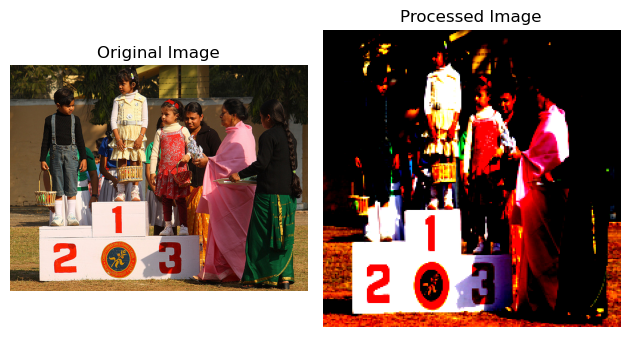

In [8]:
fig, axs = plt.subplots(1, 2)

# Original Image
axs[0].imshow(original_image)
axs[0].set_title("Original Image")

# Preprocessed Image
axs[1].imshow(normalized_image.permute(1, 2, 0))
axs[1].set_title("Processed Image")

for ax in axs:
    ax.axis('off')

plt.tight_layout()
plt.show()

- Extracting Features from Transformed Images

Utilizing pretrained weights is a beneficial approach, especially considering that the weights are obtained from ImageNet. ImageNet is a large and diverse dataset that encompasses a wide range of images, making the pretrained weights valuable for various computer vision tasks. 

Below are some of the available pretrained models:

**AlexNet:** `alexnet`

**VGG models:** `vgg11`, `vgg13`, `vgg16`, `vgg19`

**VGG models with batch normalization:** `vgg11_bn`, `vgg13_bn`, `vgg16_bn`, `vgg19_bn`

**ResNet models:** `resnet18`, `resnet34`, `resnet50`, `resnet101`, `resnet152`

**ResNeXt models:** `resnext50_32x4d`, `resnext101_32x8d`

**Wide ResNet models:** `wide_resnet50_2`, `wide_resnet101_2`

**Inception v3:** `inception_v3`

**DenseNet models:** `densenet121`, `densenet169`, `densenet201`, `densenet161`

**GoogLeNet:** `googlenet`

**ShuffleNet v2 models:** `shufflenet_v2_x0_5`, `shufflenet_v2_x1_0`, `shufflenet_v2_x1_5`, `shufflenet_v2_x2_0`

These pretrained models have learned rich representations from ImageNet and can be used as feature extractors for various image-related tasks.

In [9]:
# Load the feature extraction model
def load_model(model_name='densenet201', feature_size=2176):
    try:
        model_func = getattr(models, model_name)
        model = model_func(pretrained=True)  
    except KeyError:
        raise ValueError(f'{model_name} is not a valid model name.')

    # Remove the final fully connected layer (classifier)
    model = nn.Sequential(*list(model.children())[:-1])
    
    # Add a new fully connected layer to reduce dimensionality
    model = nn.Sequential(model, nn.Linear(model[-1].in_features, feature_size))
    
    model = model.to(device)
    model.eval()
    
    return model

# Save features, so it only have to be computed once
def save_features_to_pickle(features, output_file):
    with open(output_file, 'wb') as f:
        pkl.dump(features, f)

# Load the features 
def load_features_from_pickle(input_file):
    with open(input_file, 'rb') as f:
        features = pkl.load(f)
    return features

# Extract image features
def extract_image_features(images_path, model_name, batch_size=64):
    pickle_file = 'dataset/features_densenet.pkl'

    if os.path.exists(pickle_file):
        print("Loading features from pickle file...")
        features = load_features_from_pickle(pickle_file)
        print("Successfully loaded features from pickle file")
        
        return features

    image_files = os.listdir(images_path)
    dataloader = DataLoader(image_files, batch_size=batch_size, shuffle=False)

    features = {}
    for batch in tqdm(dataloader, total=len(image_files)//batch_size):
        batch_images = []
        for img_name in batch:
            if img_name.endswith('.jpg'):
                try:
                    img = Image.open(os.path.join(images_path, img_name)).convert('RGB')
                    img = preprocess(img).unsqueeze(0).to(device)
                    batch_images.append(img)
                except Exception as e:
                    print(f"Skipping image {img_name} due to error: {e}")
                    continue
        batch_images = torch.cat(batch_images, 0)
        
        with torch.no_grad():
            model = load_model(model_name)
            feature = model(batch_images)
        
        for img_name, feature in zip(batch, feature.cpu()):
            features[img_name] = torch.flatten(feature).numpy()

    save_features_to_pickle(features, pickle_file)
    return features


In [10]:
# Extracting features with resnet18
features = extract_image_features(images_folder, model_name = 'densenet201')


Loading features from pickle file...
Successfully loaded features from pickle file


In [11]:
image_filename = "667626_18933d713e.jpg"  # Replace with your image filename

if image_filename in features:
    print(features[image_filename])
else:
    print(f"No features found for image {image_filename}")


[[1.0810550e-04 1.1961685e-03 5.5749674e-04 ... 1.2044357e-03
  7.5977939e-01 2.3673835e-01]]


### $\color{palevioletred}{\text{(2) Caption Preprocessing}}$

- Loading captions

In [14]:
captions_text = pd.read_csv("dataset/captions.txt")
captions_text.head(2)

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .


- Useful functions

In [15]:
# Preprocessing steps on the captions to prepare them for training the model

def text_preprocessing(text):
    # Convert all text to lowercase
    text['caption'] = text['caption'].str.lower()

    # Remove any characters that are not letters
    text['caption'] = text['caption'].str.replace("[^a-z]", " ")

    # Replace any sequence of whitespace characters with a single space
    text['caption'] = text['caption'].str.replace("\s+", " ")

    # Remove single letter words.
    text['caption'] = text['caption'].apply(remove_single_letter_words)

    # Add start and end tokens to each caption. These tokens will help during the training of the model
    text['caption'] = "startseq " + text['caption'] + " endseq"

    return text

# Remove single-letter words
def remove_single_letter_words(text):
    return " ".join([word for word in text.split() if len(word) > 1])

In [16]:
data = text_preprocessing(captions_text)
captions = data['caption'].tolist()
captions[:2]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq']

- Tokenization and Vocabulary Creation

- Generating Training and Validation datasets

In [17]:
tokenizer = Tokenizer(oov_token="<UNK>")
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 2  # +1 for the zero padding token and +1 for the oov_token.

max_length = max(len(caption.split()) for caption in captions)

images = data['image'].unique().tolist()
nimages = len(images)

split_index = round(0.8*nimages)
train_images = images[:split_index]
val_images = images[split_index:]

train_df = data[data['image'].isin(train_images)]
val_df = data[data['image'].isin(val_images)]

train_df.reset_index(inplace=True,drop=True)
val_df.reset_index(inplace=True,drop=True)

print(tokenizer.texts_to_sequences([captions[1]])[0])
print(max_length)

[2, 19, 314, 64, 195, 117, 3]
35


In [18]:
print(train_df.shape)
print(val_df.shape)
max_length_val = max(len(caption.split()) for caption in val_df['caption'])
print("Maximum sequence length in validation set: ", max_length_val)


(32365, 2)
(8090, 2)
Maximum sequence length in validation set:  29


### $\color{palevioletred}{\text{(3) Data Loaders}}$ !!needs to be changed

The inputs for the training process will be the image embeddings and their corresponding caption text embeddings. 

- Useful functions

In [19]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

class ImageCaptionDataset(Dataset):
    
    def __init__(self, df, tokenizer, image_features, max_length):
        self.df = df
        self.tokenizer = tokenizer
        self.image_features = image_features
        self.max_length = max_length

        self.pairs = []
        for _, row in self.df.iterrows():
            image_id = row['image']
            image_feature = self.image_features.get(image_id)
            if image_feature is None:
                continue

            caption = row['caption']
            sequence = [idx+1 for idx in self.tokenizer.texts_to_sequences([caption])[0]]


            for i in range(1, len(sequence)):
                in_seq, out_seq = sequence[:i], sequence[i]
                in_seq_tensor = torch.full((self.max_length,), 0, dtype=torch.long)
                in_seq_tensor[:len(in_seq)] = torch.tensor(in_seq)
                out_seq_tensor = torch.tensor(out_seq, dtype=torch.long)
                self.pairs.append((image_feature, in_seq_tensor, out_seq_tensor))

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        image_feature, in_seq, out_seq = self.pairs[idx]
        X1, X2, y = torch.tensor(image_feature, dtype=torch.float32), in_seq, out_seq
        return X1, X2, y



- Create the dataset and dataloader

In [20]:
train_dataset = ImageCaptionDataset(train_df, tokenizer, features, max_length)
val_dataset = ImageCaptionDataset(val_df, tokenizer, features, max_length)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)


In [21]:
# Get the first batch
first_batch = next(iter(train_dataloader))

# Unpack the batch''''';;sda
X1, X2, y = first_batch

# Print
print('X1:', X1)
print('X2:', X2)
print('y:', y)

print('X1:', X1.shape)
print('X2:', X2.shape)
print('y:', y.shape)

X1: tensor([[[6.6276e-05, 8.6468e-04, 1.5779e-03,  ..., 6.6078e-01,
          7.1054e-01, 7.8864e-01]],

        [[1.3875e-04, 7.9708e-04, 1.4978e-03,  ..., 5.1795e-01,
          1.8416e+00, 9.1538e-01]],

        [[1.1042e-04, 5.0571e-04, 9.1459e-04,  ..., 5.4190e-01,
          1.5268e-01, 4.2097e-02]],

        ...,

        [[9.7307e-05, 8.5925e-04, 1.5508e-03,  ..., 1.5689e-01,
          1.3311e+00, 9.7402e-01]],

        [[1.8913e-04, 6.2007e-04, 6.7514e-04,  ..., 2.7645e+00,
          6.7219e-01, 1.6884e+00]],

        [[6.6246e-05, 8.3388e-04, 1.8283e-03,  ..., 0.0000e+00,
          3.2566e-01, 6.9744e-01]]])
X2: tensor([[   3, 1670,   22,  ...,    0,    0,    0],
        [   3,   12,    9,  ...,    0,    0,    0],
        [   3,   12,    5,  ...,    0,    0,    0],
        ...,
        [   3,   48,   64,  ...,    0,    0,    0],
        [   3,   19,    9,  ...,    0,    0,    0],
        [   3,   12,  107,  ...,    0,    0,    0]])
y: tensor([   4,    9,   51,    8,  124, 1663,

X1 is a tensor of image features. Each row corresponds to the features of one image.

X2 is a tensor of caption sequences, padded to the maximum length. Each row corresponds to the sequence of words (encoded as integers) in one caption, with 0s padding shorter sequences.

y is a tensor of target word sequences. Each row corresponds to a one-hot encoded target word (encoded as integers) for the corresponding caption sequence in X2.

In the context of an image captioning task, each row in X2 and y is essentially a part of a caption, and the task is to predict the next word (in y) given the current words (in X2) and the image features (in X1). The one-hot encoding in y means that each target word is represented as a vector of zeros, with a 1 at the index corresponding to the word's integer encoding.

---

## LSTM Model

---

### $\color{palevioletred}{\text{(1) Model Definition}}$

To generate the captions we will use an LSTM (Long Short Term Memory) model....

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

class CaptioningModel(nn.Module):
    def __init__(self, input_dim, vocab_size, embedding_dim, hidden_dim, max_length, dropout=0.5):
        super(CaptioningModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(input_dim + embedding_dim, hidden_dim, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, vocab_size)
        self.dropout = nn.Dropout(dropout)
        self.max_length = max_length

    def forward(self, image_features, captions):
        embeddings = self.embedding(captions)
        image_features = image_features.expand(-1, self.max_length, -1)  # repeat along the sequence length dimension
        inputs = torch.cat((image_features, embeddings), dim=2)
        lstm_outputs, _ = self.lstm(inputs)
        x = self.dropout(lstm_outputs[:, -1, :])
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Define the model
input_dim = 1920  # update this to match the DenseNet201 features
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 256
hidden_dim = 512
max_length = max_length  # Assuming this is defined in your code
dropout = 0.5

model = CaptioningModel(input_dim, vocab_size, embedding_dim, hidden_dim, max_length, dropout)
model = model.to(device)  # Don't forget to move the model to the GPU if you're using one


### $\color{palevioletred}{\text{(2) Training the model}}$

- Parameters definition

In [21]:
# def nested_dict(original_dict):
#     nested_dict = {}
#     for key, value in original_dict.items():
#         parts = key.split(".")
#         d = nested_dict
#         for part in parts[:-1]:
#             if part not in d:
#                 d[part] = {}
#             d = d[part]
#         d[parts[-1]] = value
#     return nested_dict

In [22]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from typing import Dict
# import random


# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# def train(config: Dict = None):
#     random_number = random.randint(1, 1000)
    
#     with wandb.init(config=config, name = 'LSTM_V2_' + str(random_number)):
        
#         # Get the hyperparameters from the config for this run
#         run_config = wandb.config
#         config = nested_dict(run_config)
        
#         optimizer_config = config["optimizer"]
        
#         # Define the model, optimizer, and criterion
#         model = CaptioningModel(input_dim, vocab_size, embedding_dim, config['hidden_size'], max_length, dropout = config['dropout'])
#         model.to(device)

#         optimizer = optim.Adam(model.parameters(), lr=optimizer_config['lr'])
        
#         criterion = nn.CrossEntropyLoss(ignore_index=0)  # Assuming padding index is 0

#         wandb.watch(model, log="all")

#         # Training loop
#         num_epochs = 2

#         for epoch in range(num_epochs):
#             total_loss = 0.0
#             validation_loss = 0.0

#             # Training
#             model.train()
#             for i, (image_features, captions, targets) in enumerate(train_dataloader):
#                 image_features = image_features.to(device)
#                 captions = captions.to(device)
#                 targets = targets.to(device)

#                 optimizer.zero_grad()

#                 outputs = model(image_features, captions)

#                 # Reshape targets to match outputs
#                 targets = targets.view(-1)

#                 loss = criterion(outputs.view(-1, vocab_size), targets)
#                 loss.backward()
#                 optimizer.step()

#                 total_loss += loss.item()

#                 if (i + 1) % 100 == 0:
#                     average_loss = total_loss / 100
#                     print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_dataloader)}], Loss: {average_loss:.4f}')
#                     total_loss = 0.0
                    
#                     # Log metrics to wandb
#                     wandb.log({"epoch": epoch, "Training_average_loss": average_loss})
            
#             # Validation
#             model.eval()
#             with torch.no_grad():
#                 for i, (image_features, captions, targets) in enumerate(val_dataloader):
#                     image_features = image_features.to(device)
#                     captions = captions.to(device)
#                     targets = targets.to(device)

#                     outputs = model(image_features, captions)

#                     # Reshape targets to match outputs
#                     targets = targets.view(-1)

#                     val_loss = criterion(outputs.view(-1, vocab_size), targets)

#                     validation_loss += val_loss.item()

#                 average_val_loss = validation_loss / len(val_dataloader)
#                 print(f'Validation Loss: {average_val_loss:.4f}')

#                 # Log metrics to wandb
#                 wandb.log({"epoch": epoch, "Validation_average_loss": average_val_loss})

#     wandb.finish()


In [28]:
# import yaml
# with open('config.yaml', 'r') as stream:
#     try:
#         sweep_config = yaml.safe_load(stream)
#     except yaml.YAMLError as exc:
#         print(exc)

# sweep_id = wandb.sweep(sweep_config, project="dlnn-project_ia-group_10")
# wandb.agent(sweep_id = sweep_id, function=train)

# Without wandb

In [23]:
#caption generation part
def evaluate(image_features, model, max_length, tokenizer):
    # Expand the dimensions of image_features tensor and convert it to a tensor
    image_features = torch.unsqueeze(torch.tensor(image_features, dtype=torch.float32), 0).to(device)
    # Initialize an input tensor with start token
    input_seq = torch.full((1, max_length), 0, dtype=torch.long).to(device)
    input_seq[0, 0] = tokenizer.word_index['startseq']

    model.eval()
    with torch.no_grad():
        for i in range(1, max_length):
            outputs = model(image_features, input_seq)
            _, predicted = torch.max(outputs, 1)
            input_seq[0, i] = predicted[0]

            if tokenizer.index_word[predicted[0].item()] == 'endseq':
                break

    caption = []
    for token in input_seq[0].tolist():
        word = tokenizer.index_word[token]
        if word != 'startseq':
            caption.append(word)
        if word == 'endseq':
            break

    return ' '.join(caption)


# Evaluation function for multiple images
def evaluate_multiple(images, ground_truth_captions, model, max_length, tokenizer):
    for image_name, ground_truth_caption in zip(images, ground_truth_captions):
        predicted_caption = evaluate(features[image_name], model, max_length, tokenizer)

        print(f"Image: {image_name}")
        print(f"Ground truth caption: {ground_truth_caption}")
        print(f"Predicted caption: {predicted_caption}")
        print("\n")

- Generating captions

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from typing import Dict
import random
# Trained the model for one epoch, just to have something
# Specify a path to save the model
MODEL_PATH = "edy_model_dense_high_lr_new.pth"

# try:
#     # Load the weights from the saved file
#     model.load_state_dict(torch.load('edy_model_dense_high_lr.pth'))
# except:
#     pass

num_epochs = 50

optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)  # decrease learning rate by a factor of 0.1 every 10 epochs

criterion = nn.CrossEntropyLoss(ignore_index=0)  # Assuming padding index is 0

# Move model to the right device
model = model.to(device)

# Training loop
for epoch in range(num_epochs):
    total_loss = 0.0
    validation_loss = 0.0

    # Training
    model.train()
    for i, (image_features, captions, targets) in enumerate(train_dataloader):
        image_features = image_features.to(device)
        captions = captions.to(device)
        targets = targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(image_features, captions)

        targets = targets.view(-1)

        loss = criterion(outputs.view(-1, vocab_size), targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if (i + 1) % 100 == 0:
            average_loss = total_loss / 100
            if (i+1)% 500 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_dataloader)}], Loss: {average_loss:.4f}')
            total_loss = 0.0
            
    # Decrease learning rate after every epoch
    scheduler.step()

    # Sample evaluation for multiple images
    images = val_df['image'].values[:10]  # Taking 10 images as an example, modify as needed
    ground_truth_captions = val_df['caption'].values[:10]

    evaluate_multiple(images, ground_truth_captions, model, max_length, tokenizer)

# Save the model
torch.save(model.state_dict(), MODEL_PATH)



Epoch [1/50], Step [500/5176], Loss: 18.7164


KeyboardInterrupt: 

---

## Evaluation

---